# Pytorch 개발 Process

1. **데이터 준비**
    - Dataset 준비
    - Dataloader 생성

2. **입력과 출력을 연결하는 Layer(층)으로 이뤄진 네트워크(모델)을 정의**
    - **Sequential 방식**: 순서대로 쌓아올린 네트워크로 이뤄진 모델을 생성하는 방식
        - layer를 순서대로 쌓은 모델을 구현할때 간단히 모델을 정의할 수 있다.
        - layer block을 정의하는데 사용할 수 있다.
    - **Subclass 방식**: 네트워크를 정의하는 클래스를 구현.
        - 다양한 구조의 모델을 정의할 수 있다.
        - inializer에서 필요한 layer들을 생성한다.
        - forward(self, X) 메소드에 forward propagation 계산을 구현한다.
    

3. **train**
    - train 함수, test 함수 정의

4. test set 최종평가

# MNIST 이미지 분류 
- **[MNIST](https://ko.wikipedia.org/wiki/MNIST_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B2%A0%EC%9D%B4%EC%8A%A4) (Modified National Institute of Standards and Technology) database**
- 흑백 손글씨 숫자 0-9까지 10개의 범주로 구분해놓은 데이터셋
- 하나의 이미지는 28 * 28 pixel 의 크기
- 6만개의 Train 이미지와 1만개의 Test 이미지로 구성됨.

## import

In [68]:
import torch
import torch.nn as nn  # 다양한 layer/모델 들이 정의된 패키지. (Neural Network)
from torch.utils.data import DataLoader # DataLoader 클래스 -> 모델에 데이터들을 제공하는 역할.
from torchvision import datasets, transforms 
# torchvision 패키지(라이브러리): pytorch의 Image 전용 sub package
### datasets(모듈): Vision(영상) 데이터셋들을 제공하는 모듈
### transforms: 이미지(영상) 전처리 기능들을 제공하는 모듈
import matplotlib.pyplot as plt

In [69]:
torch.__version__

'2.2.2'

### device 설정

In [70]:
# !nvidia-smi

In [130]:
# 어느 Device에서 연산처리를 할지 지정. (cpu, cuda(GPU))
# device = "cpu"
print(torch.cuda.is_available())  # cuda를 사용할 수있는 환경인지 조회
device = "cuda" if torch.cuda.is_available() else "cpu" # 2.0이전: torch.Device("cuda")
print(device)

False
cpu


In [129]:
# MAC OS  ("cpu", "mps")
# device = "cuda" if torch.backends.mps.is_available() else "cpu"
# print(device)

### 하이퍼파라미터, 변수 설정

In [73]:
lr = 0.001 # 학습률. 0 ~ 1 실수. 
batch_size = 256  # 모델을 학습할 때 한 번에 몇개의 데이터를 제공할 지 개수.
# step: 모델의 파라미터들을 update하는 단위.
#                                     (1 step: batch_size(256)만큼의 데이터로 파라미터를 한번 update)
# epoch: train set 전체를 학습하는 단위. (1 epoch: 총데이터개수(60000개)만큼 한번 다 학습한 것.)
epochs = 20

In [74]:
import os
# 학습이 끝난 모델을 저장할 디렉토리.
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)
# Dataset을 저장할 디렉토리
dataset_dir = "datasets/mnist"
os.makedirs(dataset_dir, exist_ok=True)

### MNIST dataset Loading

#### Dataset

In [75]:
trainset = datasets.MNIST(
    root=dataset_dir, # Dataset을 읽어올 디렉토리.
    download=True,    # root 에 dataset이 없을 경우 다운로드 받을지 여부.
    transform=transforms.ToTensor()
)
testset = datasets.MNIST(
    root=dataset_dir,
    download=True,
    train=False,       # Trainset인지 여부. True(default): train set, False: test set
    transform=transforms.ToTensor()
)
# transform=함수 -> input data를 전처리하는 함수를 전달.
# transforms.ToTensor
## ndarray, PIL.Image 객체를 torch.Tensor 로 변환.
## (height, width, channel) 순서를 channel first (channel, height, width) 형태로 변환.
## pixcel값들(0~255 정수)을 0 ~ 1 로 정규화. (Feature Scaling - MinMaxScaling)

In [76]:
testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: datasets/mnist
    Split: Test
    StandardTransform
Transform: ToTensor()

In [77]:
# 개별데이터 조회
trainset[0]  # tuple: (X, y)

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [78]:
trainset[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [79]:
import numpy as np
a = np.array(trainset[0][0])  # PIL.Image -> ndarray
print(a.shape)
a.min(), a.max()

(1, 28, 28)


(0.0, 1.0)

In [80]:
########## transforms.ToTensor() 적용 후################
f1 = trainset[0][0]
print(f1.shape)  # (1:channel-grayscale, 28: height, 28:width)
print(f1.dtype, f1.type())
print(f1.min(), f1.max())

torch.Size([1, 28, 28])
torch.float32 torch.FloatTensor
tensor(0.) tensor(1.)


60000


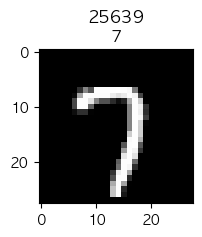

In [81]:
import random
print(len(trainset))
idx = random.randint(0, len(trainset)) #0 ~ 60000 사이 랜덤 정수를 반환.
img, label = trainset[idx]

plt.figure(figsize=(2, 2))
plt.imshow(img.squeeze(), cmap="gray") # (1, 28, 28) -> (28, 28). matplotlib은 이미지를 (h, w, c) 로 전달해야함.
plt.title(f"{idx}\n{label}")
plt.show()    

In [82]:
# 객체를 함수처럼 사용.
class Test:

    def test(self):
        print("Test객체.test()")

t = Test()
t.test()

Test객체.test()


In [83]:
class ToTensor2:

    def __call__(self):
        print("Test객체.test()")
t = ToTensor2()
t()  # t.__call__() -> callable (함수, 메소드, __call__() 정의한 객체)

Test객체.test()


#### DataLoader

In [84]:
# DataLoader: Dataset의 데이터들을 모델에 제공하는 역할. 데이터들을 모델에 어떻게 제공할지 설정해서 생성.
## Dataset: 데이터들을 가지고 있는 역할. 하나씩 조회하는 기능을 제공.
train_loader = DataLoader(
    trainset, # Dataset
    batch_size=batch_size, # batch size (256)
    shuffle=True,  # 모델에 데이터를 제공하기 전에 섞을지 여부. (default: False) True: 한 epoch 학습 전에 섞는다.
    drop_last=True, # 모델에 제공할 데이터의 개수가 batch_size보다 적으면 제공하지 않는다. (학습에 사용안함)
)

test_loader = DataLoader(testset, batch_size=batch_size)

In [85]:
# 1 epoch 당 step 수.
len(train_loader), len(test_loader)

(234, 40)

In [86]:
# 데이터 개수.
len(trainset), len(testset)

(60000, 10000)

### 모델 정의

In [87]:
# subclass(상속) 방식
## nn.Module 상속한 클래스를 정의.
## __init__(): 순전파 연산(추론)에 필요한 layer들을 생성.
## forward(): 연산 로직을 정의

In [88]:
class MNISTModel(nn.Module):
    def __init__(self):
        super().__init__()  # 상위클래스 nn.Module 을 초기화.
        #input feature개수, output 개수
        # 첫번째 Linear() : 입력데이터(X_train)을 입력. (input-입력데이터 feature수에 맞춘다.)
        self.lr1 = nn.Linear(784, 128) # (784:(28*28) image의 pixcel수, 출력: 128)
        self.lr2 = nn.Linear(128, 64)  # (128: lr1의 출력개수, 출력: 64)
        self.lr3 = nn.Linear(64, 32)   # (64: lr2의 출력개수, 출력: 32)
        self.lr4 = nn.Linear(32, 10)   # (32: lr3의 출력개수, 출력: 10 -> y의 class개수.)
        # 마지막 Linear(): 출력 크기(10) - 분류: class개수(0 ~ 9)
    def forward(self, X):
        """
        X를 입력 받아서 y를 추론하는 계산로직을 정의
        initializer에서 정의한 Linear들을 이용해서 계산.
        parameter:
            X: torch.FloatTensor - 추론할 MNIST 이미지들.
                                shape: (batch_size, 1, 28, 28) - batch_size개수의 이미지를 받아서 추론
        """
        # (batch_size, 1, 28, 28) 를 (batch_size, 784) feature들을 1차원으로 변환.
        X = torch.flatten(X, start_dim=1) # 다차원 배열을 1차원 배열로 변환. (start_dim=1, 0축은 놔두고 1축 부터 flatten시킨다.)
        X = self.lr1(X)  # Linear: 선형함수
        X = nn.ReLU()(X) # Activation(활성) 함수. 비선형함수. ReLU(x) - max(x, 0)
        X = self.lr2(X)
        X = nn.ReLU()(X)
        X = self.lr3(X)
        X = nn.ReLU()(X)
        output = self.lr4(X)
        return output

In [89]:
####### flatten() 함수 테스트.
v = torch.arange(30).reshape(5, 2, 3)
print(v.shape)
v2 = torch.flatten(v, start_dim=1)
v2.shape

torch.Size([5, 2, 3])


torch.Size([5, 6])

In [90]:
v2

tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29]])

### Train

#### 모델, loss function, optimizer 생성

In [91]:
# 모델 객체 생성. device로 옮김
model = MNISTModel().to(device) # 이 모델(의 파라미터들)을 연산을 처리할 device(cpu, cuda)로 이동.
print(model)

MNISTModel(
  (lr1): Linear(in_features=784, out_features=128, bias=True)
  (lr2): Linear(in_features=128, out_features=64, bias=True)
  (lr3): Linear(in_features=64, out_features=32, bias=True)
  (lr4): Linear(in_features=32, out_features=10, bias=True)
)


In [92]:
# loss함수
##  다중 분류 문제 -> crossentropy loss함수를 이용. (이진분류: binary crossentropy, 회귀: mse)
loss_fn = nn.CrossEntropyLoss()  # torch.nn.functional.cross_entropy 함수

In [93]:
# optimizer 정의 -> 파라미터 업데이트, 파라미터의 gradient값을 초기화.
optimizer = torch.optim.Adam(model.parameters(), lr=lr) #(모델의 파라미터들, 학습률)

In [94]:
####### 생성한 모델로 학습전에 추론.########
# Data
X_batch, y_batch = next(iter(train_loader))  # batch_size만큼 데이터를 추출, (X, y)
X_batch.shape, y_batch.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

In [95]:
# X, y를 model과 같은 device로 이동.
X_batch, y_batch = X_batch.to(device), y_batch.to(device)

In [96]:
y_pred = model(X_batch)

In [97]:
# 첫번째 데이터의 예측결과
y_pred[0]  # 가장 큰값을 가진 index가 예측 class가 된다.

tensor([-0.1242, -0.1623, -0.1407,  0.1019,  0.0468, -0.0451,  0.1918, -0.1568,
        -0.0445, -0.1756], device='mps:0', grad_fn=<SelectBackward0>)

In [98]:
y_pred[0].argmax()

tensor(6, device='mps:0')

In [99]:
y_pred.argmax(dim=-1)

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], device='mps:0')

In [100]:
# 오차 계산
loss = loss_fn(y_pred, y_batch)
loss

tensor(2.2927, device='mps:0', grad_fn=<NllLossBackward0>)

In [101]:
# 모델 파라미터 업데이트
## gradient 계산
loss.backward()

In [102]:
## 업데이트
optimizer.step()

In [103]:
## 파라미터 gradient 초기화
optimizer.zero_grad()
####################################### 1 step 학습.

#### 학습(훈련-train) 및 검증

In [104]:
# device로 이동할 대상: Model객체, X(input), y(output) => 같은 device에 위치해야함.

In [105]:
model = MNISTModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [125]:
import time
# 학습
## 에폭별 검증결과들을 저장할 리스트
train_loss_list = []
valid_loss_list = []
valid_acc_list = []
s = time.time()

# 학습-중첩 반복문: epoch 반복 -> step(batch_size) 에 대한 반복
for epoch in range(epochs):
    ###############################################
    # 모델 Train - 1 epoch : Trainset
    ###############################################
    model.train() # 모델을 train 모드로 변환.
    train_loss = 0 # 현재 epoch의 train loss를 저장할 변수.

    # batch 단위로 학습 -> 1 step: 1개 batch의 데이터로 학습.
    for X_train, y_train  in train_loader: # 한번 반복할 때마다 1개 batch 데이터를 순서대로 제공. 
        # 1. devcie로 이동
        X_train, y_train = X_train.to(device), y_train.to(device)
        # 2. 모델을 이용해 추론
        pred = model(X_train) # Model.forward(X_train) 메소드 호출
        # 3. loss 계산
        loss = loss_fn(pred, y_train)
        # 4. gradient 계산
        loss.backward()
        # 5. 모델의 파라미터들(weight, bias) update
        optimizer.step()
        # 6. gradient 초기화
        optimizer.zero_grad()
        #----------- 1step 학습
        train_loss = train_loss + loss.item() # 학습 결과 저장및 출력을 위해 loss 저장.

    
    train_loss = train_loss / len(train_loader)  # 1 에폭학습 한 loss 평균계산.
    train_loss_list.append(train_loss)
    
    ###############################################
    # 1 epoch 학습한 결과 검증: Testset
    ###############################################
    model.eval()  # 모델을 evaluation() (추론, 검증) 모드로 변환.
    valid_loss = 0
    valid_acc = 0
    with torch.no_grad(): # 추론만 함 -> gradient 계산할 필요 없음. -> grad_fn 구할 필요없다.
        for X_valid, y_valid in test_loader:
            # 1. device 로 이동
            X_valid, y_valid = X_valid.to(device), y_valid.to(device)
            # 2. 추론
            pred_valid = model(X_valid)
            # 3-1. 검증 -> loss
            valid_loss = valid_loss + loss_fn(pred_valid, y_valid).item()
            # 3-2. 검증 -> accuracy
            ## pred_valid shape: (256, 10: class별 확률) -> 정답 class 추출
            pred_valid_class = pred_valid.argmax(dim=-1)
            valid_acc = valid_acc + torch.sum(y_valid == pred_valid_class).item()
        # 검증결과 누적값의 평균
        valid_loss = valid_loss / len(test_loader)  # step수 나눔.
        valid_acc = valid_acc / len(testset)        # 데이터 개수로 나눔.
        valid_loss_list.append(valid_loss)
        valid_acc_list.append(valid_acc)

        # 검증 결과 출력
        print(f"[{epoch+1:02d}/{epochs}] train_loss: {train_loss}, valid_loss: {valid_loss}, valid_acc: {valid_acc}")

e = time.time()
print('학습에 걸린 시간(초):', e-s)

[01/20] train_loss: 0.02835105745217357, valid_loss: 0.0804135558893904, valid_acc: 0.9777
[02/20] train_loss: 0.02567334730639799, valid_loss: 0.0788676672427755, valid_acc: 0.978
[03/20] train_loss: 0.019271665582091063, valid_loss: 0.08927366151110619, valid_acc: 0.9756
[04/20] train_loss: 0.018927819827873994, valid_loss: 0.0824909239730914, valid_acc: 0.9785
[05/20] train_loss: 0.016675920622685973, valid_loss: 0.08571800743661698, valid_acc: 0.9775
[06/20] train_loss: 0.01528392518317311, valid_loss: 0.08971839804241881, valid_acc: 0.9771
[07/20] train_loss: 0.01299079908276948, valid_loss: 0.08812519993098249, valid_acc: 0.9768
[08/20] train_loss: 0.009210875620030694, valid_loss: 0.08516441947340354, valid_acc: 0.9795
[09/20] train_loss: 0.008826876831794174, valid_loss: 0.09207029443896317, valid_acc: 0.9767
[10/20] train_loss: 0.008682677514092902, valid_loss: 0.10282929333293396, valid_acc: 0.9774
[11/20] train_loss: 0.006382108955548551, valid_loss: 0.0953768279774522, vali

In [ ]:
len(train_loader)
# next(iter(train_loader))

In [ ]:
len(test_loader)

#### 학습 로그 시각화

In [ ]:
# train loss, valid loss, valid acc 를 epoch 별로 어떻게 변하는지 시각화.
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_loss_list, label="train loss")
plt.plot(range(1, epochs+1), valid_loss_list, label="valid loss")
plt.title("Loss")
plt.legend()
plt.grid(True, linestyle=":")

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), valid_acc_list)
plt.title("valid accuracy")

plt.tight_layout()
plt.grid(True, linestyle=":")
plt.show()


### 학습된 모델 저장 및 불러오기

In [107]:
import os
model_dir = "models"
save_path = os.path.join(model_dir, "mnist_model.pt")
save_path

'models/mnist_model.pt'

In [108]:
# 모델 저장: 파일 확장자 - pt, pth
torch.save(model, save_path)  #  (저장할 모델, 저장할 파일 경로)

In [122]:
# 저장된 모델 load(불러오기)
load_model = torch.load(save_path)
print(load_model)

MNISTModel(
  (lr1): Linear(in_features=784, out_features=128, bias=True)
  (lr2): Linear(in_features=128, out_features=64, bias=True)
  (lr3): Linear(in_features=64, out_features=32, bias=True)
  (lr4): Linear(in_features=32, out_features=10, bias=True)
)


## 모델 성능 최종 평가

In [110]:
load_model = load_model.to(device)
load_model.eval() # 평가모드

test_loss = test_acc = 0
with torch.no_grad():
    for X_test, y_test in test_loader:
        # device 이동
        X_test, y_test = X_test.to(device), y_test.to(device)
        # 추론
        pred_test = load_model(X_test)
        # 검증 - loss
        loss_test = loss_fn(pred_test, y_test)
        test_loss += loss_test.item()
        # 검증 - accuracy
        ## class
        pred_test_class = pred_test.argmax(dim=-1)
        test_acc += torch.sum(pred_test_class == y_test).item()

    test_loss = test_loss / len(test_loader)
    test_acc = test_acc / len(testset)

In [111]:
print(test_loss, test_acc)

0.08376458295970224 0.976


In [112]:
print(y_test.shape)
y_test

torch.Size([16])


tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6], device='mps:0')

In [113]:
p = load_model(X_test)
p.shape

torch.Size([16, 10])

In [114]:
p_class = p.argmax(dim=-1)

In [115]:
torch.sum(y_test == p_class).item() # 맞은 것의 개수.

16

## 새로운 데이터 추론

In [116]:
from PIL import Image

def load_data(device="cpu", *path):
    """
    1. 전달받은 경로의 이미지 파일들을 읽는다.
    2. 28 x 28 로 resize
    3. torch.Tensor로 변환 + 전처리
    4. devcie로 이동시킨 뒤 리턴.
    """
    input_tensors = []
    for p in path:
        img = Image.open(p)
        img = img.convert('L')     # grayscale로 변환.
        img = img.resize((28, 28)) # 모델이 학습한 데이터 size(28, 28)로 변환.
        img = transforms.ToTensor()(img)
        input_tensors.append(img)
        
    return torch.stack(input_tensors).to(device)

In [117]:
# from PIL import Image
# import numpy as np
# a = Image.open("test_img/num/five.png")  # 이미지를 읽어서 PIL.Image 객체로 반환.
# a = a.convert("L")  # rgba => grayscale(L)
# a = a.resize((28, 28))
# print(type(a))
# a = transforms.ToTensor()(a)
# print(type(a))
# # an = np.array(a)
# a.shape  # (48: height, 51: width, 4: channel) -> (48, 51)
# a.max(), a.min()

In [118]:
def predict(model, inputs, device="cpu"):
    """
    받은 model로 받은 inputs를 추론한 결과를 반환.
    결과는 class들을 반환.
    """
    with torch.no_grad():
        model = model.to(device)
        model.eval()
        pred = model(inputs)
        pred_class = pred.argmax(dim=-1)
        return pred_class
        # print(pred.shape)
        # print(pred)
        # print(pred.argmax(dim=-1))

In [119]:
# glob을 이용해 테스트 이미지들의 경로 조회.
from glob import glob
file_list = glob("test_img/**/*.png")
file_list

['test_img/num/three.png',
 'test_img/num/eight2.png',
 'test_img/num/three2.png',
 'test_img/num/two.png',
 'test_img/num/four.png',
 'test_img/num/two2.png',
 'test_img/num/eight.png',
 'test_img/num/five.png',
 'test_img/num/one.png',
 'test_img/num/seven.png',
 'test_img/num/seven3.png',
 'test_img/num/seven2.png']

In [131]:
r = load_data(device, *file_list)
# r.shape, r.min(), r.max()
result_pred = predict(load_model, r)
result_pred

tensor([3, 1, 3, 2, 4, 2, 6, 5, 8, 7, 7, 2])

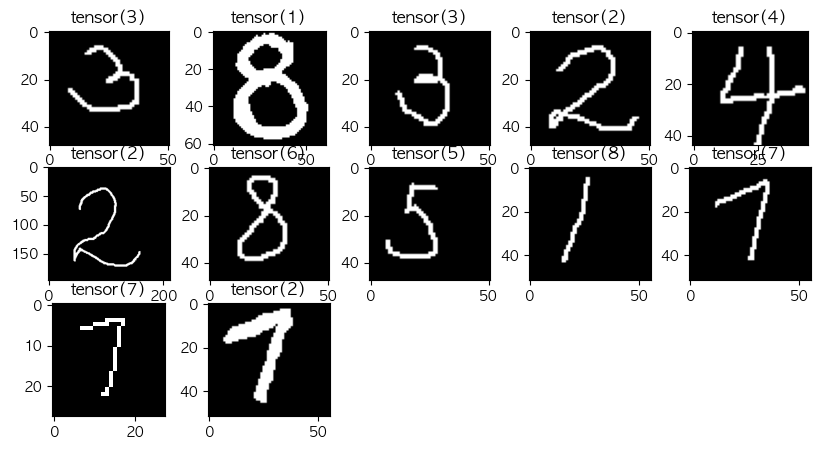

In [139]:
plt.figure(figsize=(10, 5))
for idx, (path, label) in enumerate(zip(file_list, result_pred)):
    # print(idx, path, label, sep=" , ")
    img = Image.open(path).convert('L')
    plt.subplot(3, 5, idx+1)
    plt.imshow(img, cmap='gray')
    plt.title(label)
    

In [31]:
# from sklearn.metrics import accuracy_score
# accuracy_score([8, 8], result_pred)